# ДОМАШНЯЯ РАБОТА ПО ТЕМЕ "Функции потерь и оптимизация"

Данильченко Вадим

ЗАДАНИЕ:
Дана статистика пользователей adult.csv.

Получите значения AUC для различных моделей и их параметров. Попробуйте построить модель с улучшенным значением AUC, чем в примерах на занятии (LogisticRegression, AUC: 0.6311452091928271 на коротком наборе фичей).

In [38]:
import pandas as pd
data = pd.read_csv('affair_data.csv')
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


посмотрим на тип данных

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
rate_marriage      6366 non-null float64
age                6366 non-null float64
yrs_married        6366 non-null float64
children           6366 non-null float64
religious          6366 non-null float64
educ               6366 non-null float64
occupation         6366 non-null float64
occupation_husb    6366 non-null float64
affair             6366 non-null int64
dtypes: float64(8), int64(1)
memory usage: 447.7 KB


<BarContainer object of 5 artists>

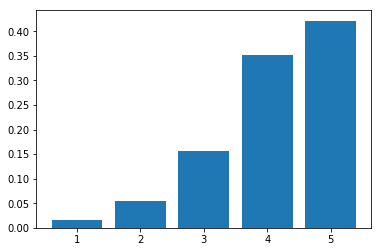

In [40]:
import matplotlib.pyplot as plt
plt.bar(sorted(data.rate_marriage.unique(), reverse=True), data.rate_marriage.value_counts()/data.shape[0])

видим, что самая большая доля оценок rate_marriage равна 5

посмотрим на долю людей с романом на стороне в данном рейтинге

In [41]:
data[data.affair==1].rate_marriage.value_counts()/data[data.affair==1].shape[0]

4.0    0.352655
3.0    0.266439
5.0    0.237214
2.0    0.107647
1.0    0.036045
Name: rate_marriage, dtype: float64

порядок изменился - самую большую долю по изменам держат те, кто поставил рейтинг 4, на втором месте 3 и третьем 5, самое интересное, что совсем неудовлетворенные (рейтинг 1) браком можно сказать не имеют никого на стороне - думаю их можно исключить из выборки, чтобы не создавать помех модели

In [42]:
data=data[data.rate_marriage!=1].copy()

посмотрим на возраст

In [43]:
data.age.value_counts()/data.shape[0]

27.0    0.305090
22.0    0.285623
32.0    0.167066
42.0    0.121589
37.0    0.098612
17.5    0.022020
Name: age, dtype: float64

больше всего респондентов в возрасте 27 и 22 года (в сумме 59%)

посмотрим в каком возрасте больше всего имеют место романы на стороне

In [44]:
data[data['affair']==1].age.value_counts()/data[data['affair']==1].shape[0]

27.0    0.313795
32.0    0.205659
22.0    0.201617
42.0    0.142496
37.0    0.129864
17.5    0.006569
Name: age, dtype: float64

больше всего романов в группе с возрастом 27 лет - 31%, 

думаю возраст 17,5 можно исключить из выборки, так как его доля 2%, а доля измен менее 1%, когда у всех остальных от 13% - шум

In [45]:
data=data[data['age']!=17.5].copy()
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


период в браке

In [47]:
data.yrs_married.value_counts()/data.shape[0]

2.5     0.317344
6.0     0.184533
16.5    0.129874
23.0    0.127753
9.0     0.097569
13.0    0.093327
0.5     0.049600
Name: yrs_married, dtype: float64

2,5 года - самый частый в этой выборке, посмотрим на долю целевой переменной

In [48]:
data[data['affair']==1].yrs_married.value_counts()/data[data['affair']==1].shape[0]

2.5     0.212106
6.0     0.194303
16.5    0.177518
23.0    0.164293
9.0     0.127670
13.0    0.116989
0.5     0.007121
Name: yrs_married, dtype: float64

2,5 года также лидер по количеству романов (21%), а вот 0,5 лет менее 1 процента - удалим из выборки (доля небольшая, зато значения будут более похожи на остальные) 

In [49]:
data=data[data['yrs_married']!=0.5].copy()

посмотрим на количество детей и зависит ли доля измен от их количества

In [52]:
data.children.value_counts()/data.shape[0]

0.0    0.343176
2.0    0.248584
1.0    0.190043
3.0    0.130472
4.0    0.054421
5.5    0.033305
Name: children, dtype: float64

больше всего в выборке людей без детей (34%), самый близкий к этому проценту результат - 2 ребенка (25%), 

есть значение 5,5 детей, возможно так отмечали всех более 5, либо это ошибка 

In [54]:
data[data['affair']==1].children.value_counts()/data[data['affair']==1].shape[0]

2.0    0.299180
0.0    0.242316
1.0    0.201332
3.0    0.155738
4.0    0.064037
5.5    0.037398
Name: children, dtype: float64

при двух детях количество романов 30%, а странная группа 5,5 имеет 4% положительных значений таргета и 3% долю наблюдений в наших данных - также уберем

In [57]:
data=data[data['children']!=5.5].copy()

рассмотрим religious - возможно религиозность

In [59]:
data.religious.value_counts()/data.shape[0]

3.0    0.379329
2.0    0.357130
1.0    0.163559
4.0    0.099982
Name: religious, dtype: float64

In [60]:
data[data['affair']==1].religious.value_counts()/data[data['affair']==1].shape[0]

2.0    0.400745
3.0    0.341671
1.0    0.202767
4.0    0.054816
Name: religious, dtype: float64

максимально верущие имеют самый низкий процент измен

изучим educ-образование (возможно в годах)

In [63]:
data.educ.value_counts()/data.shape[0]

14.0    0.362991
12.0    0.317350
16.0    0.177411
17.0    0.082223
20.0    0.053277
9.0     0.006748
Name: educ, dtype: float64

In [64]:
data[data['affair']==1].educ.value_counts()/data[data['affair']==1].shape[0]

14.0    0.400213
12.0    0.342735
16.0    0.138371
17.0    0.069186
20.0    0.040979
9.0     0.008515
Name: educ, dtype: float64

видим, что в основном чем меньше значение educ, тем больше процент отношений на сторооне, исключение только значение 9 - и маленький процент от выборки и менее 1% изменяющих - удалим

In [65]:
data=data[data['educ']!=9.0].copy()

occupation - предположу, что это трудовая занятость

In [66]:
data.occupation.value_counts()/data.shape[0]

3.0    0.437511
4.0    0.293760
2.0    0.126408
5.0    0.118362
6.0    0.017879
1.0    0.006079
Name: occupation, dtype: float64

In [67]:
data[data['affair']==1].occupation.value_counts()/data[data['affair']==1].shape[0]

3.0    0.476114
4.0    0.232958
5.0    0.152442
2.0    0.114868
6.0    0.019860
1.0    0.003757
Name: occupation, dtype: float64

1 - самая маленькая группа (менее одного процента) и в ней еще меньше романов - удалим, а вот 3 - почти половина всех наблюдений и половина из них имеет романы

In [68]:
data=data[data['occupation']!=1.0].copy()

occupation_husb - предположу, что это трудовая занятость партнера

In [69]:
data.occupation_husb.value_counts()/data.shape[0]

4.0    0.322000
5.0    0.282245
2.0    0.197697
6.0    0.086346
3.0    0.078791
1.0    0.032920
Name: occupation_husb, dtype: float64

In [70]:
data[data['affair']==1].occupation_husb.value_counts()/data[data['affair']==1].shape[0]

4.0    0.309806
5.0    0.294181
2.0    0.204203
3.0    0.086207
6.0    0.081358
1.0    0.024246
Name: occupation_husb, dtype: float64

тут 4 - самая многочисленная категория, особых выбросов нет

# построение модели

отделим таргет

In [71]:
y=data['affair']
X=data.drop('affair', axis=1)

сменим всем признакам тип на object

In [78]:
for col in X.columns:
    X[col]=X[col].astype(object)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5559 entries, 0 to 6365
Data columns (total 8 columns):
rate_marriage      5559 non-null object
age                5559 non-null object
yrs_married        5559 non-null object
children           5559 non-null object
religious          5559 non-null object
educ               5559 non-null object
occupation         5559 non-null object
occupation_husb    5559 non-null object
dtypes: object(8)
memory usage: 390.9+ KB


все переменные имеют ограниченное количество значений, скорее сгруппированные в некоторые группы - преобразуем их в dummy-переменные

In [81]:
X=pd.get_dummies(X)
X.columns

Index(['rate_marriage_2.0', 'rate_marriage_3.0', 'rate_marriage_4.0',
       'rate_marriage_5.0', 'age_22.0', 'age_27.0', 'age_32.0', 'age_37.0',
       'age_42.0', 'yrs_married_2.5', 'yrs_married_6.0', 'yrs_married_9.0',
       'yrs_married_13.0', 'yrs_married_16.5', 'yrs_married_23.0',
       'children_0.0', 'children_1.0', 'children_2.0', 'children_3.0',
       'children_4.0', 'religious_1.0', 'religious_2.0', 'religious_3.0',
       'religious_4.0', 'educ_12.0', 'educ_14.0', 'educ_16.0', 'educ_17.0',
       'educ_20.0', 'occupation_2.0', 'occupation_3.0', 'occupation_4.0',
       'occupation_5.0', 'occupation_6.0', 'occupation_husb_1.0',
       'occupation_husb_2.0', 'occupation_husb_3.0', 'occupation_husb_4.0',
       'occupation_husb_5.0', 'occupation_husb_6.0'],
      dtype='object')

разобьем на тренировочную и тестовую выборки

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

приведем к одному масштабу

In [83]:
from sklearn.preprocessing import StandardScaler
train_x_sc=pd.DataFrame(StandardScaler().fit_transform(X_train))
test_x_sc=pd.DataFrame(StandardScaler().fit_transform(X_test))

построим модель логистической регрессии

In [103]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression().fit(train_x_sc, y_train)
y_train_predict = logreg.predict_proba(train_x_sc)
y_test_predict = logreg.predict_proba(test_x_sc)

In [109]:
import numpy as np
from sklearn.metrics import accuracy_score, auc,roc_curve,roc_auc_score
print('accuracy: {}'.format(accuracy_score(y_test, np.round(y_test_predict[:, 1]))))
print('roc_auc_score: {}'.format(roc_auc_score(y_test, np.round(y_test_predict[:, 1]))))

accuracy: 0.7146282973621103
roc_auc_score: 0.634482658319692


посчитаем AUC

In [137]:
m_score=0
best_score=0
best_state=0
best_state_list=[]

for r_state in range(1,102,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = r_state)
    
    train_x_sc=pd.DataFrame(StandardScaler().fit_transform(X_train))
    test_x_sc=pd.DataFrame(StandardScaler().fit_transform(X_test))
    
    logreg=LogisticRegression().fit(train_x_sc, y_train)
    y_test_predict = logreg.predict(test_x_sc)

    fpr, tpr, thres = roc_curve( y_test, y_test_predict)

    m_score=auc( fpr, tpr )
    best_state_list.append(m_score)
    if m_score>best_score:
        best_score=m_score
        best_state=r_state
        
print('best auc: {}'.format(best_score))
print('best random_state: {}'.format(best_state))
# print(best_state_list)

best auc: 0.6494454383409954
best random_state: 62


используем l1 и l2 и посмотрим на изменение AUC

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 62)

train_x_sc=pd.DataFrame(StandardScaler().fit_transform(X_train))
test_x_sc=pd.DataFrame(StandardScaler().fit_transform(X_test))

logreg1=LogisticRegression(penalty = 'l1', C = 0.01 ).fit(train_x_sc, y_train)
y_test_predict1 = logreg1.predict(test_x_sc)

logreg2=LogisticRegression(penalty = 'l2', C = 0.01 ).fit(train_x_sc, y_train)
y_test_predict2 = logreg2.predict(test_x_sc)


fpr1, tpr1, thres1 = roc_curve( y_test, y_test_predict1)
fpr2, tpr2, thres2 = roc_curve( y_test, y_test_predict2)

print('l1 auc: {}'.format(auc( fpr1, tpr1 )))
print('l2 auc: {}'.format(auc( fpr2, tpr2 )))

l1 auc: 0.6146942123691468
l2 auc: 0.6480853312284832


получается для l1 auc меньше